# Data Fundamentals (H)
John H. Williamson / Sebastian Stein -- Session 2023/2024

----

**This submission must be your own work; you will have to make a Declaration of Originality on submission.**

---

## LinAlg
# Vector spaces and linear transforms

## Purpose of this lab
This lab should help you:
* understand how data can be represented as points in vector space
* understand the effect of different vector norms
* apply linear transforms to vectors
* apply principal component analysis using eigendecompositions
* boost your whisky tasting skills

## Guidance
You will need to understand the following functions well to complete this lab:
* [`np.argmin()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html) [Unit 1]
* [`np.argsort()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argsort.html) [Unit 1]
* [`np.linalg.norm()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html) [Unit 4]

For last section of Part D/E:
* [`np.linalg.svd()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) [Unit 5]
* [`np.linalg.eigh()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.eigh.html) [Unit 5]
* [`np.cov()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.cov.html) [Unit 4]


In [1]:
# RUN THIS
# Make sure you run this cell!
# NumPy
import numpy as np
import binascii

# Set up Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc("figure", figsize=(8.0, 4.0), dpi=140)

# custom utils
from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import jhwutils.tick as tick
np.set_printoptions(suppress=True)

def case_crc(s):
    h_crc = binascii.crc32(bytes(s.lower(), "ascii"))
    print(h_crc)
    return h_crc

def anagram_crc(l):
    return case_crc("".join(sorted(l)))


assert case_crc("data fundamentals") == 3540753417
# ignore any warnings below, they don't affect the results
print("Everything imported OK")

3540753417
Everything imported OK


## Whisky: Representing and comparing vectors

Whisky distillation is a major industry in Scotland. 

<img src="imgs/stills.jpg"> <br><br>*.[Image](https://flickr.com/photos/sashafatcat/518104633 "stills") by [sashafatcat](https://flickr.com/people/sashafatcat) shared [CC BY](https://creativecommons.org/licenses/by/2.0/)*

### Whisky vectors
The dataset in `data/whisky.csv` is data from a number of whisky distilleries. For each distillery, there is a set of subjective judgements about the flavour characteristics of their product. The data comes from [this Strathclyde University research project](https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html).

Each distillery has been judged on twelve flavour indicators (like "smokiness" or "sweetness"), and they have been assigned values from 0-5, indicating the strength of that category as judged by an expert whisky drinker. These can be seen as 12D vectors, one vector per distillery. **Every distillery is represented as a point in twelve dimensional vector space.**


## Loading the data

In [2]:
# RUN THIS
## It is not necessary to understand this code to complete
# the exercise. We don't cover pandas in DF(H)
import pandas as pd

### Load and clean the whisky data
whisky_df = pd.read_csv("data/whiskies.txt")
whisky_df = whisky_df.sort_values(by="Distillery")
# extract the column and row names
whisky_names = np.array(whisky_df["Distillery"])

columns = {name.lower(): index for index, name in enumerate(whisky_df.columns[2:-3])}
column_indices = [""]*len(columns)
for k, v in columns.items():
    column_indices[v] = k
    
print(column_indices)

# split apart the data frame and form numpy arrays
whisky_locations = np.array(whisky_df.iloc[:, -2:])
_whisky = np.array(whisky_df.iloc[:, 2:-3])

print(whisky_locations)
print(_whisky)

# load word vectors
word_vectors = np.load("data/glove_vecs.npz")
word_vecs = word_vectors["word_vecs"]
words = word_vectors["words"]

print(words)

# force tie breaks by adding a bit of fixed noise
np.random.seed(2018)
whisky_vecs = _whisky + np.random.uniform(0, 1.0, _whisky.shape)

if check_hash(whisky_vecs, ((86, 12), 1010833.7554104808)):
    print("Whisky data loaded OK")
else:
    print("Something weird is going on. Ask for help!")

if check_hash(word_vecs, ((50000, 300), -546776578572.11)):
    print("Word vectors loaded OK")

['body', 'sweetness', 'smoke', 'medicinal', 'tobacco', 'honey', 'spice', 'wine', 'nutty', 'malt', 'fruit', 'floral']
[[ 286580  749680]
 [ 326340  842570]
 [ 352960  839320]
 [ 141560  646220]
 [ 355350  829140]
 [ 194050  649950]
 [ 247670  672610]
 [ 340754  848623]
 [ 340754  848623]
 [ 270820  885770]
 [ 307750  827170]
 [ 332680  840840]
 [ 212600  775710]
 [ 323450  858380]
 [ 325800  839920]
 [ 303330  859350]
 [ 242260  554260]
 [ 294860  757580]
 [ 131330  659720]
 [ 126680  661400]
 [ 142210  673170]
 [ 142920  670040]
 [ 318790  843090]
 [ 290250  904230]
 [ 316600  836370]
 [ 328920  844920]
 [ 323520  841010]
 [ 266610  868730]
 [ 263670  785270]
 [ 271570  701570]
 [ 332360  839200]
 [ 295960  757940]
 [ 372120  860400]
 [ 322640  861040]
 [ 381020  827590]
 [ 327610  849570]
 [ 340754  848623]
 [ 319820  862320]
 [ 251810  850860]
 [ 172090  621010]
 [ 327760  849140]
 [ 326490  841240]
 [ 361200  844930]
 [ 333000  840300]
 [ 320950  838160]
 [ 332680  840840]
 [ 252810

## Viewing the data
We can see this whole whisky dataset as a heatmap:

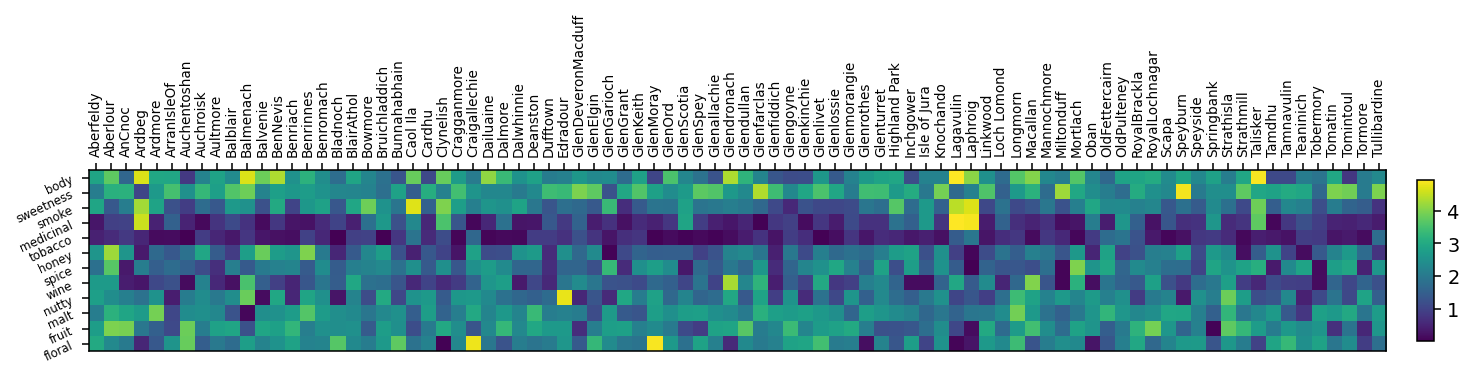

In [3]:
# RUN THIS
# show a plot of the whisky data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

# image plot
img = ax.imshow(whisky_vecs.T)
ax.set_xticks(np.arange(len(whisky_names)))
ax.set_xticklabels(whisky_names, rotation=90, fontsize=7)

# put the x axis at the top
ax.xaxis.tick_top()
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns, rotation=25, fontsize=6)
plt.tight_layout()
fig.colorbar(img, orientation="vertical",  ticks=np.arange(6), aspect=10, pad=0.02, shrink=0.15);


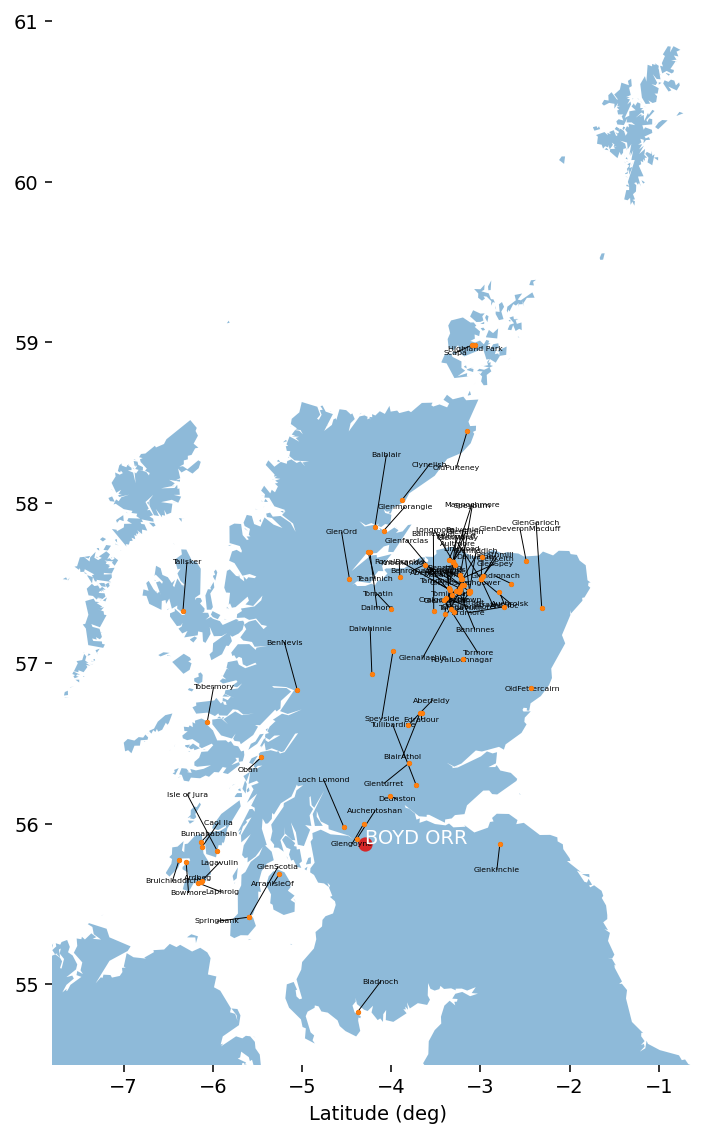

In [4]:
# RUN THIS
# and the locations
from whisky_map import draw_map, map_box, map_circle
# draw each distillery label at the locations given.
ax = draw_map(whisky_locations, whisky_names)

### Available data
You now have these variables:

* `whisky_vecs` an  86x12 array of taste judgements, one row for each of the 86 distilleries. Each whisky has a rating 0-5 for each of the 12 flavour categories.
* `whisky_names` is a list of 86 distillery names
* `whisky_locations` an 86x2 array of the geographical locations of each distillery
* `columns` is a mapping of whisky feature names to column indices.
* `column_indices` maps column indices to whisky feature names

For example:

In [5]:
print(whisky_vecs.shape)

(86, 12)


In [6]:
# how smoky is Glenfiddich?
print(whisky_vecs[whisky_names.searchsorted("Glenfiddich"), columns["smoke"]])

1.0897226718562112


In [7]:
# what column is "smoke"? What name is column 4?
print(columns["smoke"], column_indices[4])

2 tobacco


In [8]:
# What is the full 12D flavour profile of Glenfiddich
print(whisky_vecs[whisky_names.searchsorted("Glenfiddich")])

[1.32664113 3.42010124 1.08972267 0.80801688 0.26109704 0.43601682
 0.6115702  0.42135283 0.92576906 2.80226673 2.29784509 2.16788936]


In [9]:
# what is the name of the whisky at index 8?
print(whisky_names[8])  

Aultmore


In [10]:
# Where is Glengoyne? 
print(whisky_locations[whisky_names.searchsorted("Glengoyne")])

[252810 682750]


# A: Norms, interpolation and statistics
We will see some simple things we can do with this dataset. 


## Task A.1 Utilities
When working with data it is often useful to define convenience functions to access data. Define a function `get_flavour(name)` that returns the 12 element flavour vector for the given whisky distillery name. You may find it useful to define other short functions to tidy up your code in the following exercises. 

**Note: Write short simple functions throughout the lab! Do not try and cram NumPy code into a single line.**

In [11]:
# YOUR CODE HERE
def get_flavour(name):
    return (whisky_vecs[whisky_names.searchsorted(name)])
                        
print(get_flavour('Glenfiddich'))

[1.32664113 3.42010124 1.08972267 0.80801688 0.26109704 0.43601682
 0.6115702  0.42135283 0.92576906 2.80226673 2.29784509 2.16788936]


In [12]:
## Tests
with tick.marks(2):
    assert np.allclose(get_flavour("Glenlivet"), [2.62286833, 3.54181922, 1.07385158, 0.78503541, 0.02922946, 2.14009029,
 2.51030532, 2.98123896, 1.85897206, 2.64742671, 2.72418747, 3.44808261])
    assert np.allclose(get_flavour("Tormore"), [2.05370498, 2.06330895, 1.46170648, 0.57475477, 0.15731167, 1.72180689,
 0.46893117, 1.59631266, 2.87923014, 1.91986016, 0.54801949, 0.89967727])
    
    

## Task A.2 Distance profiles
We can compute distances in **flavour space** between whisky distilleries.

Compute the $L_\infty$ distance of `Mannochmore` to `Craigellachie` and store it in `m_c_distance`. This is a distance in flavour space, not physical distance.

In [13]:
# YOUR CODE HERE
m = get_flavour('Mannochmore')
c = get_flavour('Craigellachie')
m_c_distance = np.linalg.norm((m-c), ord=np.inf)
print(m_c_distance)

1.834163019867824


In [14]:
## Tests
with tick.marks(2):
    assert check_hash(m_c_distance,((), 9.17081509933912))

## Task A.3 All distances
Compute the $L_1$ flavour space distance between `Glengoyne` and *every* distillery. Store the result in `glengoyne_distances`. The result should be a 1D array of length 86.

In [15]:
# YOUR CODE HERE
g = get_flavour('Glengoyne')

all_flavours = get_flavour(whisky_names)
print(all_flavours)

abs_diffs = np.abs(g - all_flavours)
glengoyne_distances = np.sum(abs_diffs, axis=1)
print(glengoyne_distances)

[[2.88234931 2.10432774 2.90700933 ... 2.10721508 2.75709253 2.99967101]
 [3.725931   3.14144824 1.3567206  ... 3.17180956 3.97689051 2.33022414]
 [1.62904415 3.16061095 2.08995264 ... 2.90093449 3.93393613 2.04737714]
 ...
 [0.81314974 3.87814596 1.5964869  ... 2.99282859 1.90878026 2.40485389]
 [2.05370498 2.06330895 1.46170648 ... 1.91986016 0.54801949 0.89967727]
 [2.32616051 3.97354659 0.73014837 ... 2.73541499 2.60362534 1.79944122]]
[ 9.00049467 11.6891334   7.87327372 20.18275296 11.05619141 12.32285054
  5.92616831  9.20807329  8.29803357 11.37043442 16.47328379 10.8256933
 10.22317577  7.84578148 10.82268984  7.24521676  8.28714257  9.38057102
 11.62404828  9.19916438  7.06504768 17.76026986  5.92925905 17.28331273
 10.92425452 10.4804974  11.95005373 11.08031757 10.27090927  7.94887738
  9.42487368  8.23385188 13.2108705   9.85884378 12.87722652  7.57765415
  9.93923902  8.50520328  8.64685704 12.45198066  9.27374707  7.86303627
 13.31529823  8.24806523 10.95394822  9.654679

In [16]:
## Tests
with tick.marks(2):
    assert check_hash(glengoyne_distances, ((86,), 38808.32074836765))

### Task A.4 Ranked distances
Create a variable `like_glengoyne` which is a list of the name each distillery in rank order of flavour similarity to `Glengoyne`. That is, the distillery most similar to `Glengoyne` should be first (it will be `Glengoyne`), and the distillery least similar to `Glengoyne` should be last. 


In [17]:
# YOUR CODE HERE
distances = list(zip(whisky_names, glengoyne_distances))

distances.sort(key=lambda x: x[1])

like_glengoyne = [name for name, _ in distances]

print(like_glengoyne)

['Glengoyne', 'Glenmorangie', 'Scapa', 'Auchentoshan', 'Cardhu', 'Speyside', 'Mannochmore', 'Bunnahabhain', 'Benromach', 'Glenkinchie', 'GlenGrant', 'Tamdhu', 'Tobermory', 'Longmorn', 'Benriach', 'Glenallachie', 'AnCnoc', 'Strathisla', 'Deanston', 'Glenlossie', 'Knochando', 'Loch Lomond', 'Edradour', 'Glendullan', 'Bladnoch', 'Aultmore', 'Tamnavulin', 'GlenMoray', 'GlenOrd', 'Glenlivet', 'Linkwood', 'Aberfeldy', 'RoyalBrackla', 'Bruichladdich', 'Auchroisk', 'GlenSpey', 'BlairAthol', 'Dufftown', 'RoyalLochnagar', 'Glenfiddich', 'Tullibardine', 'Glenturret', 'GlenElgin', 'GlenKeith', 'Inchgower', 'OldPulteney', 'Tomintoul', 'Strathmill', 'BenNevis', 'Dalwhinnie', 'Craigallechie', 'Tormore', 'Macallan', 'Benrinnes', 'Balvenie', 'OldFettercairn', 'Glenrothes', 'Cragganmore', 'Glenfarclas', 'Ardmore', 'Dalmore', 'Balblair', 'Miltonduff', 'Bowmore', 'Aberlour', 'Tomatin', 'Dailuaine', 'Oban', 'ArranIsleOf', 'GlenScotia', 'Teaninich', 'Speyburn', 'Highland Park', 'Mortlach', 'GlenGarioch', 'I

In [18]:
## Tests
name_list = "\n".join(["--->\t".join([f"{s:19s}" for s in like_glengoyne[i:i+4]]) for i in range(0, len(like_glengoyne), 4)])
print(name_list)

with tick.marks(4):
    assert case_crc("\n".join(like_glengoyne)) == 1669524249

Glengoyne          --->	Glenmorangie       --->	Scapa              --->	Auchentoshan       
Cardhu             --->	Speyside           --->	Mannochmore        --->	Bunnahabhain       
Benromach          --->	Glenkinchie        --->	GlenGrant          --->	Tamdhu             
Tobermory          --->	Longmorn           --->	Benriach           --->	Glenallachie       
AnCnoc             --->	Strathisla         --->	Deanston           --->	Glenlossie         
Knochando          --->	Loch Lomond        --->	Edradour           --->	Glendullan         
Bladnoch           --->	Aultmore           --->	Tamnavulin         --->	GlenMoray          
GlenOrd            --->	Glenlivet          --->	Linkwood           --->	Aberfeldy          
RoyalBrackla       --->	Bruichladdich      --->	Auchroisk          --->	GlenSpey           
BlairAthol         --->	Dufftown           --->	RoyalLochnagar     --->	Glenfiddich        
Tullibardine       --->	Glenturret         --->	GlenElgin          --->	GlenKeit

### A.5 Angle
Compute the *angle* between Tamdhu and Bowmore's flavour profiles, and store it in the variable `tamdhu_bowmore_angle`. This will just be a single number.

Hint: @, and remember angles are values in radians...

In [19]:
# YOUR CODE HERE
t = get_flavour('Tamdhu')
b = get_flavour('Bowmore')

product = np.dot(t, b)

norm_t = np.linalg.norm(t)
norm_b = np.linalg.norm(b)

tamdhu_bowmore_angle = np.arccos(product / (norm_t * norm_b))

In [20]:
## Tests
print(f"The angle between Tamdhu and Bowmore flavours is {np.degrees(tamdhu_bowmore_angle):.1f} degrees")
with tick.marks(32):
    assert check_hash(tamdhu_bowmore_angle, ((), 2.93324880352258))

The angle between Tamdhu and Bowmore flavours is 33.6 degrees


### A.6 Similar vectors
Which distillery is most like `GlenGrant`'s flavour profile under the $L_2$ norm, *other than GlenGrant itself*? Store the distillery **name** in the variable in `like_glengrant`. Note: compute this - do not hardcode it.


In [21]:
# YOUR CODE HERE
g = get_flavour('GlenGrant')

glengrant_i = np.where(np.array(whisky_names) == 'GlenGrant')[0][0]

l2_distances = np.linalg.norm(whisky_vecs - g, axis=1)

l2_distances[glengrant_i] = np.inf

like_glengrant = whisky_names[np.argmin(l2_distances)]

print(like_glengrant)

Aultmore


In [22]:
## Tests
print(
    f"The distillery most like GlenGrant (according to the L_2 norm) is {like_glengrant}."
)
with tick.marks(2):
    assert case_crc(like_glengrant) == 507585678

The distillery most like GlenGrant (according to the L_2 norm) is Aultmore.
507585678


### A.5 Dissimilar vectors
Which distillery is most distant from `Isle of Jura` *in 2D geographic location space* (not flavour space!) using $L_2$ norm? Store this in `far_from_jura`.

In [23]:
# YOUR CODE HERE
jura_coords = whisky_locations[whisky_names.searchsorted("Isle of Jura")]

l2_distances = np.linalg.norm(whisky_locations - jura_coords, axis=1)

far_from_jura = whisky_names[np.argmax(l2_distances)]

print(far_from_jura)

Highland Park


In [24]:
## Tests
print("The distillery that is physically furthest away from Isle of Jura is:", far_from_jura)
with tick.marks(2):
    assert case_crc(far_from_jura) == 2681797469

The distillery that is physically furthest away from Isle of Jura is: Highland Park
2681797469


## Task A.6 Midway island

Which distillery is *closest to* the flavour that is midway between Bowmore and Tormore (using $L_2$ norm)?

In [25]:
# YOUR CODE HERE
tormore = get_flavour('Tormore')
bowmore = get_flavour('Bowmore')

middle = (bowmore + tormore) / 2

l2_distances = np.linalg.norm(whisky_vecs - middle, axis=1)

midway_tormore_bowmore = whisky_names[np.argmin(l2_distances)]

print(midway_tormore_bowmore)

Highland Park


In [26]:
## Tests
print("The nearest distillery that tastes midway between Tormore and Bowmore is", midway_tormore_bowmore)
with tick.marks(2):
    assert case_crc(midway_tormore_bowmore) == 2681797469

The nearest distillery that tastes midway between Tormore and Bowmore is Highland Park
2681797469


## Task A.7 Words

You have also some *word embeddings* loaded. Each word embedding is a 300D vector. [These are extracts from the GLoVe embeddings](https://nlp.stanford.edu/projects/glove/). The data is stored in two variables:

* `words` a list of English words in alphabetic order
* `word_vecs` a [N, 300] numpy array of word vectors

Find the word that is closest to the midpoint between `honey` and `medicinal` (using the $L_2$ norm) *that isn't `honey` or `medicinal`*. Store the word in `midway_word`.


In [27]:
# YOUR CODE HERE
honey_i = np.where(np.array(words) == 'honey')[0][0]
medicinal_i = np.where(np.array(words) == 'medicinal')[0][0]

honey_vec = word_vecs[honey_i]
medicinal_vec = word_vecs[medicinal_i]
middle = (honey_vec + medicinal_vec)/2

l2_distances = np.linalg.norm(word_vecs - middle, axis=1)

l2_distances[honey_i] = np.inf
l2_distances[medicinal_i] = np.inf

closest_index = np.argmin(l2_distances)

midway_word = words[closest_index]

print(midway_word)


herbs


In [28]:
## Tests
with tick.marks(2):
    assert case_crc(midway_word) ==  2854902077

2854902077


<div class="alert alert-warning">
    
**Note** from now on, use the $L_2$ norm if you need to compute any norms unless the task specifies otherwise.
</div>

## B: More vector space

### B.1  Vector arithmetic
A client says to you:
    
>    I'd like something a bit more "pungent" than Craigellachie, in the same way that Aberlour is more "pungent" than Knochando.

Which whisky should you recommend? 

<div class="alert alert-info">

**Note**
* What does more "pungent" mean? We don't have a "pungent" column.
    * But we do have a reference point: Knochando -> Aberlour is somehow "pungent"
    * This "direction" between these flavour vectors is *also* a vector in the same space!
</div>

Compute:

* `pungent` A vector representing what "pungent" is.
* `hypothetical_flavour` A vector representing a hypothetical flavour that would be a more pungent version of Craigellachie.
* `recommendation_name` the name of a specific distillery that we might recommend, as a string.
* `opposite_recommendation` the name of a distillery that is a version of Craigellachie that is less "pungent".

**Note: this question is not subjective, nor does it require any trial-and-error or knowledge about whisky. Do not use word embeddings. Answer it directly using vector arithmetic in flavour space.**

In [29]:
# YOUR CODE HERE
aberlour = get_flavour('Aberlour')
knochado = get_flavour('Knochando')
craigel = get_flavour('Craigellachie')

#pungent = np.linalg.norm((a-k), ord=np.inf)
pungent = aberlour-knochado
hypothetical_flavour = craigel + pungent
less_hypothetical_flavour = craigel - pungent

dist_best = np.linalg.norm(whisky_vecs - hypothetical_flavour, axis=1)
dist_best_sorted = np.argsort(dist_best)
recommendation = whisky_names[dist_best_sorted[0]]


dist_worst = np.linalg.norm(whisky_vecs - less_hypothetical_flavour, axis=1)
dist_worst_sorted = np.argsort(dist_worst)
opposite_recommendation = whisky_names[dist_worst_sorted[0]]

print(hypothetical_flavour)


[5.67056907 1.51418712 2.3899549  0.73490767 0.44626212 2.88623929
 3.88263309 3.72832957 2.25861317 3.42550751 3.85360524 1.78533453]


In [30]:
## Tests
print(
    f"I would recommend {recommendation} as a more 'pungent' version of Craigellachie.")

I would recommend Mortlach as a more 'pungent' version of Craigellachie.


In [31]:
## Tests
with tick.marks(2):
    assert check_hash(pungent, ((12,), 58.69942028240199 ))

In [32]:
## Tests
with tick.marks(2):
    assert check_hash(hypothetical_flavour, ((12,), 226.661195331854))

In [33]:
## Tests
with tick.marks(1):
    assert case_crc(recommendation) == 752256104

752256104


In [34]:
## Tests
print(
    f"I would recommend {opposite_recommendation} as a less 'pungent' version of Craigellachie."    
)
with tick.marks(1):
    assert case_crc(opposite_recommendation) == 3231081197

I would recommend Cragganmore as a less 'pungent' version of Craigellachie.
3231081197


### B.2 Flavour tour
A client wishes to taste whiskies that are new to her. You have been told:

* The client has visited Scotland and tasted `Dalwhinnie`, `Dalmore`, and `Tullabardine`.
* She thought they were awful.
* Find the five distilleries which are as different as possible from the average flavour profile that the client has already experienced.

Store the list of names in `new_experiences`.


In [35]:
# YOUR CODE HERE
dalwhinnie = get_flavour('Dalwhinnie')
dalmore = get_flavour('Dalmore')
tullabardine = get_flavour('Tullabardine')

average_flavour_profile = (dalwhinnie + dalmore + tullabardine)/3
dist = np.linalg.norm(whisky_vecs - average_flavour_profile, axis=1)
dist_sorted = np.argsort(dist)

new_experiences = whisky_names[dist_sorted[-5:]]

print(new_experiences)

['Caol Ila' 'Balmenach' 'Ardbeg' 'Lagavulin' 'Laphroig']


In [36]:
## Tests
print("The recommended new experiences are:")

for distillery in new_experiences:
    print("\t", distillery)

The recommended new experiences are:
	 Caol Ila
	 Balmenach
	 Ardbeg
	 Lagavulin
	 Laphroig


In [37]:
## Tests
with tick.marks(4):
    assert anagram_crc(new_experiences)==1493710089

1493710089


### B.3 Auto-sommelier

You're asked to build an app that helps people find whiskies they like. One approach is to ask users for words they think describe characteristics they find appealing and translate that into the measured dimensions of the distilleries. 

Write a function `most_relevant_descriptor(word)` that
takes any English word (like "herbal" or "charred" or "musky") as input and returns the *three most similar column names* (using `column_indices`) representing the closest approximation to that word. Use the GLoVe word vectors *and the cosine distance* (not L2 norm!) for comparison. 

Return the column names in order of similarity to the word, most similar first. You can assume that the word is in the vocabulary. Loops are acceptable here but not required.

For example, you might expect "charred" to map to ["smoke", "spice", "malt"] and "sugary" to map to ["sweetness", "fruit", "spice"].

In [38]:
# YOUR CODE HERE:
print(column_indices)
def get_wordvec(name):
    return (word_vecs[words.searchsorted(name)])

# def normalize(x):
#     return x / np.linalg.norm(x)

def most_relevant_descriptor(word):
    user_word_vec = get_wordvec(word)
    column_indices_names = [name for name, _ in columns.items()]
    column_indices_vecs = get_wordvec(column_indices_names)
        
    cosine_similarities = 1.0 - np.dot( column_indices_vecs, user_word_vec) / (np.linalg.norm(column_indices_vecs, axis=1) * np.linalg.norm(user_word_vec))
    
    flavour_dist = list(zip(column_indices_names, cosine_similarities))
    flavour_dist.sort(key=lambda x: x[1])
    closest_words = [pair[0] for pair in flavour_dist[:3]]
    
    return closest_words
    
    

print(most_relevant_descriptor('charred'))


['body', 'sweetness', 'smoke', 'medicinal', 'tobacco', 'honey', 'spice', 'wine', 'nutty', 'malt', 'fruit', 'floral']
['smoke', 'malt', 'sweetness']


In [39]:
## Tests
def sommelier(c):    
    descriptors = most_relevant_descriptor(c)
    # remember to be unctuous
    print(f"Hmmm, yes, whisky that tastes like \033[1m{c}\033[0m, of course.\n\t\033[1m{c.title()}\033[0m reminds me of \033[34m{', '.join(descriptors[:-1])}\033[0m or \033[34m{descriptors[-1]}\033[0m.", end=" ")
    # slightly arbitrary recommendation
    rec_vec = np.full((12,), 1.0)
    for i,col in enumerate(descriptors):
        rec_vec[columns[col]] = 5.0 - i
    recommendation = whisky_names[np.argmin(np.linalg.norm(whisky_vecs-rec_vec, axis=1))]
    print(f"\n\tPerhaps one would care to sample \033[31m{recommendation}\033[0m?")

# these recommendations are genuinely good 
print("Welcome, I am auto-sommelier version 0.1.")
sommelier("honeysuckle")
sommelier("fire")
sommelier("caramel")
sommelier("hazelnut")
sommelier("cardamom")
sommelier("charred")
sommelier("icecream")
sommelier("absinthe")
sommelier("iodine")
sommelier("tea")
sommelier("jam")
sommelier("barley")
sommelier("licorice")
print("Uh, I seem to have had a malfunction.\nUhh.\n")
# these are less plausible...
sommelier("spanners")
sommelier("justice")
sommelier("grandma")
sommelier("dentists")
sommelier("petrol")

with tick.marks(6):
    assert case_crc(" ".join(most_relevant_descriptor("wine")[0])) ==  1829427632
    assert case_crc(" ".join(most_relevant_descriptor("honeysuckle"))) ==  850311784
    assert case_crc(" ".join(most_relevant_descriptor("tar"))) ==  885188356
    assert case_crc(" ".join(most_relevant_descriptor("whales"))) ==  3282344617
    assert case_crc(" ".join(most_relevant_descriptor("bleach"))) ==  2623215746
    
    
    

Welcome, I am auto-sommelier version 0.1.
Hmmm, yes, whisky that tastes like honeysuckle, of course.
	Honeysuckle reminds me of floral, honey or fruit. 
	Perhaps one would care to sample Auchentoshan?
Hmmm, yes, whisky that tastes like fire, of course.
	Fire reminds me of smoke, body or tobacco. 
	Perhaps one would care to sample Caol Ila?
Hmmm, yes, whisky that tastes like caramel, of course.
	Caramel reminds me of malt, sweetness or nutty. 
	Perhaps one would care to sample Cardhu?
Hmmm, yes, whisky that tastes like hazelnut, of course.
	Hazelnut reminds me of nutty, honey or malt. 
	Perhaps one would care to sample Tormore?
Hmmm, yes, whisky that tastes like cardamom, of course.
	Cardamom reminds me of spice, honey or sweetness. 
	Perhaps one would care to sample Inchgower?
Hmmm, yes, whisky that tastes like charred, of course.
	Charred reminds me of smoke, malt or sweetness. 
	Perhaps one would care to sample Ardmore?
Hmmm, yes, whisky that tastes like icecream, of course.
	Icecrea

## B.4 Average flavours

We could say that the "representative" element of a collection of vectors was the one closest to the centroid. This is given by the **mean vector** of a data set.

Compute the mean vector of all of the flavour vectors. Use it to find the names of two distilleries:
* `most_representative` The distillery with the **most** representative flavour profile
* `least_representative` The distillery with the **least** representative flavour profile

In [40]:
# YOUR CODE HERE
mean_whisky = np.mean(whisky_vecs, axis=0)
distances = np.linalg.norm(whisky_vecs - mean_whisky, axis=1)

most_representative_i = np.argmin(distances)
most_representative = whisky_names[most_representative_i]

least_representative_i = np.argmax(distances)
least_representative = whisky_names[least_representative_i]


In [41]:
## Tests
print(
    "The most representative whisky distillery is {most}, and the most unrepresentative is {least}.".format(
        most=most_representative, least=least_representative
    )
)

The most representative whisky distillery is Mannochmore, and the most unrepresentative is Laphroig.


In [42]:
## Tests
with tick.marks(2):
    assert case_crc(most_representative) == 1877523766
    assert case_crc(least_representative) == 2291391646
    

1877523766
2291391646


### B.5 A line in space
You want to give a new client a comprehensive but smooth tour through the world of whisky. You want to find a flight of whiskies that segue pleasantly from one to the next. You know your client enjoys `Caol Ila` and `Glengoyne`.

Find four distilleries as evenly spaced in *flavour space* as possible, between `Caol Ila` and `Glengoyne`. Store this sequence of names in `tour`, which should begin `Caol Ila` and end `Glengoyne`.


In [43]:
# YOUR CODE HERE
caol = get_flavour('Caol Ila')
cr = get_flavour('Glengoyne')

distance_2_vec = [((1-(i+1)/3)*caol + (((i+1)/3)*cr)) for i in range(2)]

tour = []

exclude_vecs = [whisky_names.searchsorted("Caol Ila"), whisky_names.searchsorted("Glengoyne")]
print(exclude_vecs)

for vec in distance_2_vec:
    n=0
    dist = np.linalg.norm(np.abs(whisky_vecs - vec), axis=1)
    
    most_similar_indices = np.argsort(dist)
    most_similiar_words = whisky_names[most_similar_indices[n]] if most_similar_indices[0] not in exclude_vecs else whisky_names[most_similar_indices[n+1]]  
    tour.append(most_similiar_words)
    
print(tour)   
   
tour = ['Caol Ila', tour[0], tour[1], 'Glengoyne']
    
print(tour)   
    
    

# print(distances)

[21, 46]
['OldPulteney', 'Mannochmore']
['Caol Ila', 'OldPulteney', 'Mannochmore', 'Glengoyne']


In [44]:
## Tests
print("The four distilleries are:", ", ".join(tour))
with tick.marks(4):
    assert case_crc("".join(tour)) ==  3141984355
    

The four distilleries are: Caol Ila, OldPulteney, Mannochmore, Glengoyne
3141984355


## C: Geography
### A map
The code below will show a map of Scotland, with the distilleries in their correct positions. Different geographic regions have different characteristic flavour profiles.

There are several circular *zones* of characteristic flavour profiles. The map below shows the location of the distilleries, and the geographic zones are shown as circles overlaid on the plot. Every zone has an `x,y` coordinate and a radius `r`.

A distillery is said to be in a zone if it is within that circle. If there are multiple circles that a cover a distillery, a distillery is in the zone of the circle centered closest to it.
- For example, `Deanston` is (just) in the `highland` and `lowland` zone, but is a member of `lowland` because it is closer to the center of the `lowland` zone than the `highland` zone. 



[[270000 950000 250000]
 [110000 670000  60000]
 [340000 850000  40000]
 [310000 580000 155000]
 [175000 620000  20000]]
['highland' 'island' 'speyside' 'lowland' 'campbeltown']


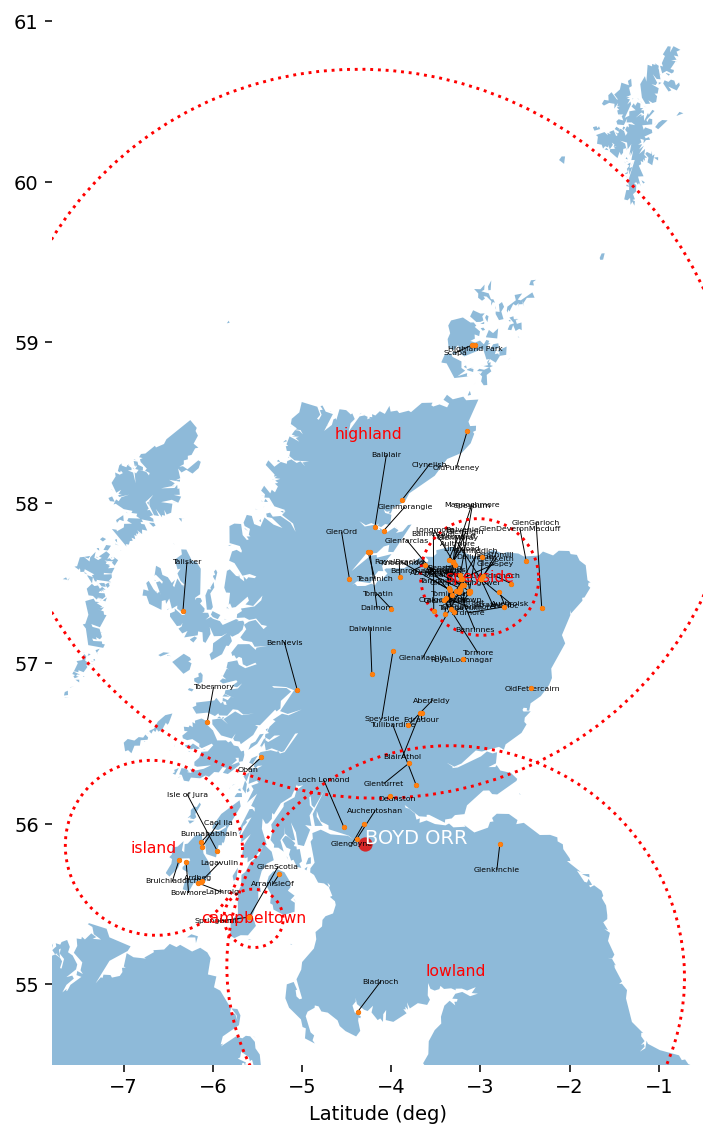

In [93]:
# RUN THIS
from whisky_map import draw_map, map_box, map_circle

# draw each distillery label at the locations given.
ax = draw_map(whisky_locations, whisky_names)

whisky_zones = {
    "highland": (270000, 950000 ,250000),
    "island": (110000, 670000 ,60000), 
    "speyside": (340000, 850000,40000),
    "lowland": (310000, 580000,155000),
    "campbeltown": (175000, 620000, 20000)
}

# the x,y,r as an array
zone_array = np.array(list(whisky_zones.values()))
zone_names = np.array(list(whisky_zones.keys()))

# show the island region
# draw a box in OS grid units
for name, (x,y, r) in  whisky_zones.items():
    map_circle(ax, (x,y), r, label=name)
    
    
print(zone_array)
print(zone_names)

### Task C.1 

Write a function `in_zone(locs)` that takes an [N,2] *array* of distillery locations and returns an array of integers of length N, where each element is the index of `zone_array` that the corresponding location is in. For example, if the first location is in the `highland` zone, the first element of the result should be `0`.

 It's fine to use loops here if you prefer. Don't beat your head against the keyboard trying to vectorise it!

In [95]:
# YOUR CODE HERE
# coords_zone_center = zone_array[:, :2]


def in_zone(locs):
    zones = []
           
    for loc in locs:
        min_dist = float('inf')
        zone_i = -1
        
        for i, (x, y, r) in enumerate(zone_array):
            dist = np.linalg.norm(np.abs(loc - np.array([x, y])))
            if dist < r and dist < min_dist:
                min_dist = dist
                zone_i = i
                
        zones.append(zone_i)    
    return zones    

print(in_zone(np.array([[270000, 950000]])))

[0]


In [96]:
## Tests
def loc(name):
    return whisky_locations[whisky_names.searchsorted(name)]

def find_zone(name):
    return zone_names[in_zone(loc(name)[None,:])[0]]

with tick.marks(4):
    t = in_zone(np.array([[5,5]])) 
    assert t == np.floor(t), "You should be returning an array of numbers, 0-4, corresponding to indices of zone_names"
    assert find_zone("Glengoyne") == "lowland", "Make sure you're using the L2 norm"
    assert find_zone("Caol Ila") == "island"
    assert find_zone("Glenturret") == "lowland", "Check that you have the right rule if two circles cover one point"
    assert find_zone("Glenkinchie") == "lowland"
    assert find_zone("Benrinnes") == "speyside"
    assert find_zone("Glenfarclas") == "speyside"
    assert find_zone("Springbank") == "campbeltown"
    assert find_zone("ArranIsleOf") == "lowland", "Remember that a point must be *inside* the circle to be in a zone, not just nearest to it!"
    assert check_hash(in_zone(whisky_locations), ((86,), 5518.587765136294))


### Task C.2
Compute the following (using the mean vector as the definition of "typical"):

* `island_flavour`: Compute the most typical whisky flavour profile for *island* whiskies. (i.e. a 12 element vector).
* `most_typical_speyside`: The specific name of the distillery from *Speyside* that is most typical of that region;
* `most_atypical_highland`: The specific name of the distillery *from the Highlands* that is most atypical of that region (i.e. furthest from the typical Highland flavour);
* `most_like_campbeltown_in_islands`: The specific name of the distillery from the `islands` that is most like a `Campbeltown` whisky;
* `most_unlike_lowland`: The name of the distillery whose typical whisky is most dissimilar to the typical lowland whisky.

**Note:** do not do any of this by hand. Write code. Use the mean as the indicator of typicality. Remember: write short functions to simplify your code and use simple data structures like dictionaries to avoid complicated code. You are a professional computer scientist!

In [98]:
# YOUR CODE HERE
mean_vec = np.mean(whisky_vecs, axis=0)

def find_zone(name):
    return zone_names[in_zone(loc(name)[None,:])[0]]

def define_region_whisky_vecs(name):
    vecs = [whisky_vecs[i] for i in range(len(whisky_vecs)) if find_zone(whisky_names[i]) == name]
    names = [whisky_names[i] for i in range(len(whisky_names)) if find_zone(whisky_names[i]) == name]
    return vecs, names

def mean_vector_in_zone(name):
    return np.mean(define_region_whisky_vecs(name)[0], axis=0)
print(mean_vector_in_zone('campbeltown'))

def define_typical_whisky_vec(zone_name):
    vecs, names = define_region_whisky_vecs(zone_name)
    mean = np.mean(vecs, axis=0)
    whisky_vec_name = names[np.argmin(np.linalg.norm(np.abs(vecs - mean), axis=1))]
    return whisky_vec_name    
    
island_whiskys, island_names = define_region_whisky_vecs('island')
island_flavour = np.mean(island_whiskys, axis=0)

most_typical_speyside = define_typical_whisky_vec('speyside')

highland_whiskys, highland_names = define_region_whisky_vecs("highland")
most_atypical_highland = highland_names[np.argmax(np.linalg.norm(highland_whiskys - mean_vec, axis=1))]

campbeltown_whiskys, _ = define_region_whisky_vecs("campbeltown")
campbeltown_mean = np.mean(campbeltown_whiskys, axis=0)
most_like_campbeltown_in_islands = island_names[np.argmin(np.linalg.norm(island_whiskys - campbeltown_mean, axis=1))]

lowland_whiskys, lowland_names = define_region_whisky_vecs("lowland")
lowland_mean = np.mean(lowland_whiskys, axis=0)
whisky_zone_vecs = [define_region_whisky_vecs(name)[0] for name in zone_names]
whisky_means = [np.mean(w, axis=0) for w in whisky_zone_vecs]
most_unlike_lowland = zone_names[np.argmax(np.linalg.norm(np.abs(whisky_means - lowland_mean), axis=1))]

print(most_unlike_lowland)


[2.54671735 2.57487535 2.59754799 2.75244762 0.44617659 2.07754836
 1.60648343 1.50821604 2.17491395 2.13136982 0.58916467 1.56067477]
island


In [99]:
## Tests
with tick.marks(2):
    assert check_hash(island_flavour, ((12,), 145.8604022320185  ))

In [100]:
print(
    "The most typical whisky of the Speyside region is {most}.".format(
        most=most_typical_speyside
    )
)
print(
    "The most atypical whisky of the Highland region is {most}.".format(
        most=most_atypical_highland
    )
)
print(
    "The most similar island whisky to the average Campbeltown whisky is {most}.".format(
        most=most_like_campbeltown_in_islands
    )
)
print(
    "The whisky most unlike lowland whiskies is {unlike}.".format(
        unlike=most_unlike_lowland
    )
)

The most typical whisky of the Speyside region is Knochando.
The most atypical whisky of the Highland region is Talisker.
The most similar island whisky to the average Campbeltown whisky is Isle of Jura.
The whisky most unlike lowland whiskies is island.


In [101]:
## Tests
with tick.marks(1):
    assert case_crc(most_typical_speyside) == 3134021644

3134021644


In [102]:
## Tests
with tick.marks(1):
    assert case_crc(most_atypical_highland) == 275020046

275020046


In [103]:
## Tests
with tick.marks(1):
    assert case_crc(most_like_campbeltown_in_islands) == 3459837550

3459837550


In [104]:
## Tests
with tick.marks(1):
    assert case_crc(most_unlike_lowland) == 2291391646

2836361194


AssertionError: 

## Task C.3

Find the following quantities:
    
* `highland_lowland`, the flavour vector that translates from the average Highland to the average Lowland whisky.
* `most_distinct_feature` the name of the element of the flavour vector that is largest in magnitude in `highland_lowland`, i.e. the most relevant column name that distinguishes Highland and Island whiskies.
* `translated_auchentoshan` the flavour vector for `Auchentoshan` translated into the flavour space of `Island` whiskies. 
* `midway_highland_lowland` The name of the distillery that is closest to halfway between the *average flavour* of the `highland` and `island` zones. 

In [107]:
# YOUR CODE HERE
def find_indices_in_zone(zone_name):
    return np.where(np.array(in_zone(whisky_locations)) == list(whisky_zones.keys()).index(zone_name))[0]

highland_indices = find_indices_in_zone("highland")
lowland_indices = find_indices_in_zone("lowland")

mean_highland = mean_vector_in_zone("highland")
mean_lowland = mean_vector_in_zone("lowland")
mean_island = mean_vector_in_zone('island')
highland_lowland = mean_lowland - mean_highland

most_distinct_feature = column_indices[np.argmax(highland_lowland)]

auchentoshan_i = np.where(whisky_names == 'Auchentoshan')[0][0]
translated_auchentoshan = whisky_vecs[auchentoshan_i] + (mean_island - mean_lowland)

average_highland_island =  (mean_highland + mean_island)/2
distances_to_midway = np.linalg.norm(whisky_vecs - average_highland_island, axis=1)
closest_distillery_i = np.argmin(distances_to_midway)
midway_highland_lowland = whisky_names[closest_distillery_i]

In [108]:
## Tests
with tick.marks(2):    
    assert check_hash(highland_lowland, ((12,), -5.880125849865902 ))

In [ ]:
## Tests
print(most_distinct_feature)
with tick.marks(2):
    assert type(most_distinct_feature) == str, "Most distinct feature should be a string, like 'smoke'"
    assert case_crc(most_distinct_feature) == 1065352022

In [ ]:
## Tests
with tick.marks(1):
    assert check_hash(translated_auchentoshan, ((12,), 162.95877758248002 ))

In [ ]:
## Tests
print(midway_highland_lowland)
with tick.marks(1):
    assert case_crc(midway_highland_lowland) == 2088351511


# D: Eigendecompositions, normalisation, relative coordinates and the SVD
The last part of this section uses ideas from Unit 5 of the course. You are welcome to attempt it in advance, but you will have to do your own research when you get to Part D.3 (note: it is quite feasible to attempt this without having seen Unit 5).

## Task D.1 Demeaning tasks
The dataset that we have is unnormalised. It is a set of ratings, 0-5, and many of the attributes rated are on quite different scales, with `tobacco` being much less likely to be rated 4 than `floral`.
It is easier to work with normalised data. 

Compute:
* `mean_whisky` the average flavour profile (you've already computed this above...)
* `std_whisky` the standard deviation of each column of the flavour vectors
* `normalised_whisky` that has the mean flavour vector removed and then divided by the column standard deviations. 


In [64]:
# YOUR CODE HERE
mean_whisky = np.mean(whisky_vecs, axis=0)
std_whisky = np.std(whisky_vecs, axis=0)
normalised_whisky = (whisky_vecs - mean_whisky) / std_whisky

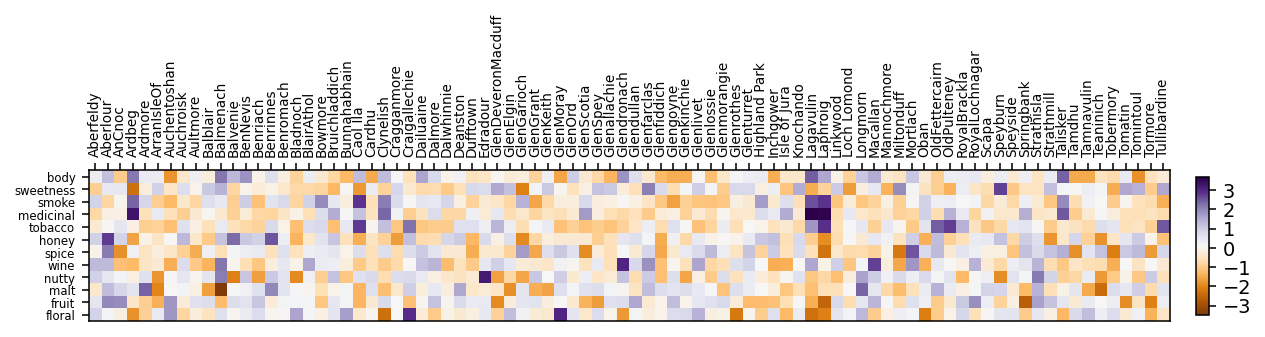

In [65]:
## RUN THIS
## Show the normalised whisky scores

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
# Note: diverging colour map because our values are signed now
img = ax.imshow(normalised_whisky.T, cmap="PuOr")

ax.set_xticks(np.arange(len(whisky_names)))
ax.set_xticklabels(whisky_names, rotation=90, fontsize=7)

# put the x axis at the top
ax.xaxis.tick_top()
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns, rotation="horizontal", fontsize=6);

fig.colorbar(img, orientation="vertical",  ticks=np.arange(-3,4), aspect=10, pad=0.02, shrink=0.16)


In [66]:
## Tests
with tick.marks(1):
    assert check_hash(mean_whisky, ((12,), 158.04069986180863))

In [67]:
## Tests
with tick.marks(1):
    assert check_hash(std_whisky, ((12,), 68.43750862536146))

In [68]:
## Tests
with tick.marks(1):
    assert check_hash(normalised_whisky, ((86, 12), -12618.67130160396 ))

## Task D.2 Covariances

Compute the **covariance matrix** of the normalised data. Call this `whisky_cov`.  The code below will show you this matrix as an image. **Note**: this should be a 12x12 matrix! The covariance matrix tells us how different columns of the dataset are correlated (co-vary) with each other.

You need to remember the `rowvar=False` argument if using `np.cov`!

In [69]:
# YOUR CODE HERE
whisky_cov = np.cov(normalised_whisky, rowvar=False)

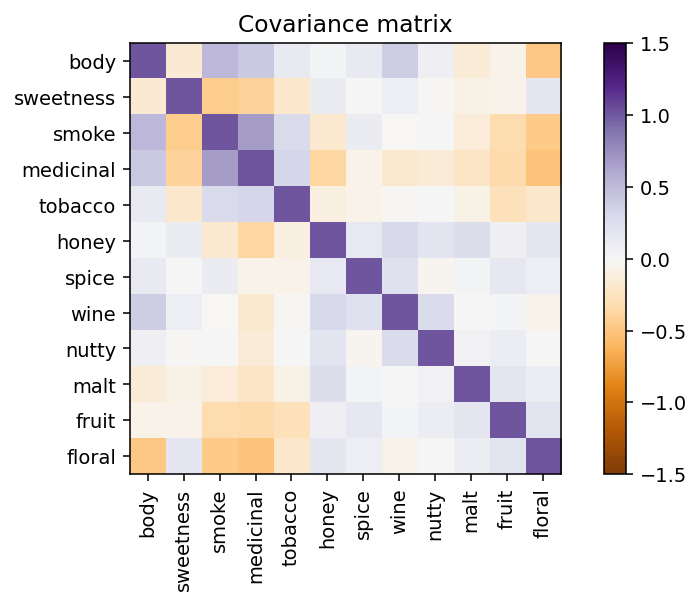

In [70]:
## Tests
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
img = ax.imshow(whisky_cov, cmap="PuOr", vmin=-1.5, vmax=1.5)
ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(12))
ax.set_yticklabels(columns)
ax.set_xticklabels(columns, rotation="vertical")
ax.set_title("Covariance matrix")
fig.colorbar(img)

with tick.marks(1):
    assert check_hash(whisky_cov, ((12, 12), 909.8122940642988))

### A television interview
Although the raters have provided 12 different categories, it seems these are not fully independent of each other. From the image of the covariance matrix of this dataset we can see several interesting relations among the way the tasters rate whisky. 

You are about to interviewed about your whisky expertise, and your producer has just handed you the covariance matrix you plotted above as a "cheat sheet". Read the following statements, and comment out the all of the "facts" that are *not* supported by this covariance matrix you see.



In [71]:
facts = []
# some of these are false; copy this cell below, 
# then comment false lines out.
facts = facts + ["wine and nutty are negatively correlated"]
facts = facts + ["wine is almost unrelated to smoke"]
facts = facts + ["body and sweetness are very positively correlated"]
facts = facts + ["smoke is negatively correlated sweetness"]
facts = facts + ["smoke is very positively correlated with medicinal"]
facts = facts + ["fruit and wine are nearly uncorrelated"]
facts = facts + ["fruit is very negatively correlated with floral"]
facts = facts + ["tobacco is most positively correlated with medicinal"]
facts = facts + ["honey is very negatively correlated with medicinal"]
facts = facts + ["wine is almost unrelated to body"]


In [72]:
# YOUR CODE HERE
facts = []
# some of these are false; copy this cell below, 
# then comment false lines out.

# facts = facts + ["wine and nutty are negatively correlated"]
facts = facts + ["wine is almost unrelated to smoke"]
# facts = facts + ["body and sweetness are very positively correlated"]
facts = facts + ["smoke is negatively correlated sweetness"]
facts = facts + ["smoke is very positively correlated with medicinal"]
facts = facts + ["fruit and wine are nearly uncorrelated"]
# facts = facts + ["fruit is very negatively correlated with floral"]
facts = facts + ["tobacco is most positively correlated with medicinal"]
facts = facts + ["honey is very negatively correlated with medicinal"]
# facts = facts + ["wine is almost unrelated to body"]


In [73]:
## Tests
with tick.marks(4):
    assert case_crc(";".join(facts))==1414729462

1414729462


### Task D.3 Relative distances

To help alleviate some of this variation, we will can first compute a new representation where vectors are transformed from the original coordinated system to a *relative* one. 

Compute the distance flavour between every distillery and every other distillery, in the $L_2$ norm as an 86x86 matrix called `all_distances`.  Use the *normalised* whisky vectors. Hint: this is easy with promotion. 

Then compute a matrix $R$ from that distance matrix, given by $$R_{ij} = e^{\left(-\frac{D_{ij}^2}{2k^2}\right)}$$ (this is sometimes called the RBF function; it just turns distances into similarities). Use `all_distances` for $D$ and `k=2.2`.

Store $R$ in a variable called `all_similarities`. This is an 86D representation of the whisky vectors as relative similarities.

The code should be about three to four lines.

In [74]:
# YOUR CODE HERE
all_distances = np.linalg.norm(normalised_whisky[:, np.newaxis] - normalised_whisky, axis=2)

k=2.2
all_similarities = np.exp(-(all_distances**2)/(2*k**2))

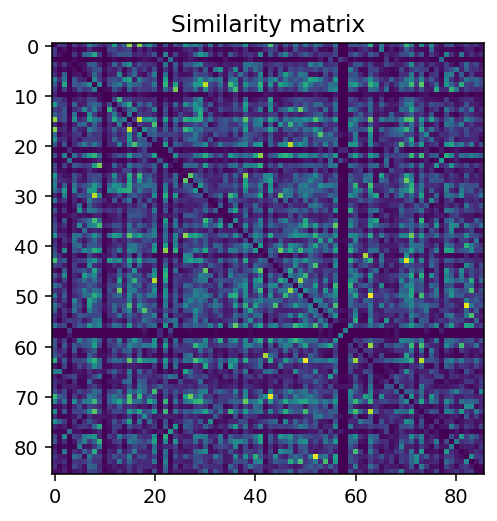

In [75]:
## Tests
fig, ax = plt.subplots(figsize=(4, 4))
# show similarities
img = ax.imshow(all_similarities - np.diag(np.diag(all_similarities)), cmap="viridis")
ax.set_title("Similarity matrix")
with tick.marks(6):   
    assert check_hash(all_distances, ((86,86), 128180687.09833793)), 'Make sure you are using the normalised whisky, and the L_2 norm'
    assert check_hash(all_similarities, ((86, 86), 4390239.570362095 )), "Check k=2.2, and that you've squared the right things"




## D.4 Biggest and smallest 

Three clients have turned up for a tasting. 

- One is conservative and wishes to try a very standard tasting whisky. 
- One is very avant garde and wishes to try a very unusual tasting whisky.
- One is called Goldilocks and wishes to try moderately exciting whisky.

Which distillery has the largest *average* distance to all other distilleries? Note: *not* the largest distance to the average distillery! That is, which distillery is the most "unusual"? Which is the most usual? Which is "median usual"?
Store these in `most_unusual`, `median_usual` and `most_usual` respectively. (Round down if you need to break a tie when computing the median).

In [76]:
# YOUR CODE HERE

average_distances = np.mean(all_distances, axis=1)
most_unusual_i = np.argmax(average_distances)
most_unusual = whisky_names[most_unusual_i]

most_usual_i = np.argmin(average_distances)
most_usual = whisky_names[most_usual_i]

sorted_distances = np.argsort(average_distances)
median_index = len(sorted_distances) // 2
median_usual_i = sorted_distances[median_index]
median_usual = whisky_names[median_usual_i]


In [77]:
## Tests
print(f"The most usual whisky is {most_usual} and the most unusual is {most_unusual}. The median usual is {median_usual}.")
with tick.marks(2):
    assert case_crc(most_usual+most_unusual) == 3080517846    
    assert case_crc(most_usual+most_unusual+median_usual) == 2224631052    

The most usual whisky is Benromach and the most unusual is Laphroig. The median usual is Bruichladdich.
3080517846
2224631052


## D.5 Eigendecomposition of the relative similarity covariance matrix

We would like to interpret this 86D similarity space stored in `all_similarities`. Each whisky is now represented by an 86D vector. Recall that the covariance matrix can be represented by an ellipse whose primary axes are the **eigenvectors** of the covariance matrix computed in this relative similarity space. The eigenvectors are a set of *independent* directions in which the dataset varies. 

These are the **principal components** of the dataset. We can compute these from the covariance matrix by taking the eigendecomposition. Each eigenvector of the covariance matrix is a **principal component** and its importance is given by the square root of the absolute value of its corresponding eigenvalue.

* Compute all 86 of the eigenvectors of the covariance matrix of the *relative similarities*, in order, with the *largest* corresponding eigenvalue first. Store these as a matrix of column vectors in `whisky_pc`. These eigenvectors are the principal components.
* Compute the square root of every eigenvalue (we can think of these as lengths of the prinicipal components) and store them in `whisky_pc_len`. Make sure they are in descending order from largest to smallest.

**Important: use `np.linalg.eigh` to compute the eigenvalues, not `np.linalg.eig`. Covariance matrices are symmetric, and `eigh` is much more stable for symmetric matrices.**

In [78]:
# YOUR CODE
eigenvals, eigenvecs = np.linalg.eigh(all_similarities)

sorted_i = np.argsort(eigenvals)[::-1]
whisky_pc = eigenvecs[:, sorted_i]
print(whisky_pc)
whisky_pc_len = np.sqrt(np.abs(eigenvals[sorted_i]))

[[ 0.12862254 -0.21497908  0.05607306 ...  0.00394022  0.16893947
  -0.02357671]
 [ 0.03801603 -0.10918704 -0.05826012 ... -0.00589797 -0.01432833
   0.00435135]
 [ 0.09336824  0.07726279  0.11186463 ...  0.00351348  0.00048213
   0.00727468]
 ...
 [ 0.09889945  0.07104368 -0.2244502  ... -0.02485812  0.05603714
  -0.00850554]
 [ 0.06982583  0.0182546   0.11186723 ...  0.00029483  0.00155446
   0.01707364]
 [ 0.06300653  0.04990069 -0.06835105 ... -0.06596992 -0.00562212
   0.00055612]]


In [79]:
## Tests
with tick.marks(4):
    print("If this works, you have correct eigenvalues and eigenvectors")
    assert check_hash(whisky_pc[:8],  ((8,86),-2179.114336565666   ))
    assert check_hash(whisky_pc_len[:8], ((8,),72.29756434227956))

If this works, you have correct eigenvalues and eigenvectors


## Task D.6 Projecting onto the principal components

You need to make a visual guide for prospective whisky buyers, who are very confused by your explanations of whisky high-dimensional space. You are going to print tea towels with a conceptual map of whisky on them.

One very useful technique is to project data onto a small number of principal components to visualise the data. For example, we might map the first two principal components to a 2D $x,y$ plot to make a tea towel that maps out "important" classes of flavour.

This is a key technique in exploratory data analysis: **principal component analysis**. All it involves is using the principal components to find a simplified mapping onto a lower-dimensional space.

We can compute a projection of a dataset onto an arbitrary set of vectors by forming a matrix product:
$$P = XV,$$

Where $P$ is an $N\times k$ matrix that is the result of the projection, $X$ is the $N \times D$ original data set and $V$ is an $D \times k$ matrix, each of whose *columns* is a vector that we want to project onto. We can find V by choosing the top $k$ principal components.

---

Use this information to project the relative similarity data (`all_similarities`) onto the first *three* principal components, and store the result in `whisky_projected_3d`. If you do this correctly, the plot below should show a preview of your teatowel design mapping of whisky flavours, where more distant distilleries in the map represent more distinct flavour styles, and the geoms are coloured by the third principal component.


In [80]:
# YOUR CODE HERE
eigenvecs_3 = whisky_pc[:, :3]
whisky_projected_3d = np.dot(all_similarities, eigenvecs_3)

Text(0.5, 1.0, 'Tea towel design')

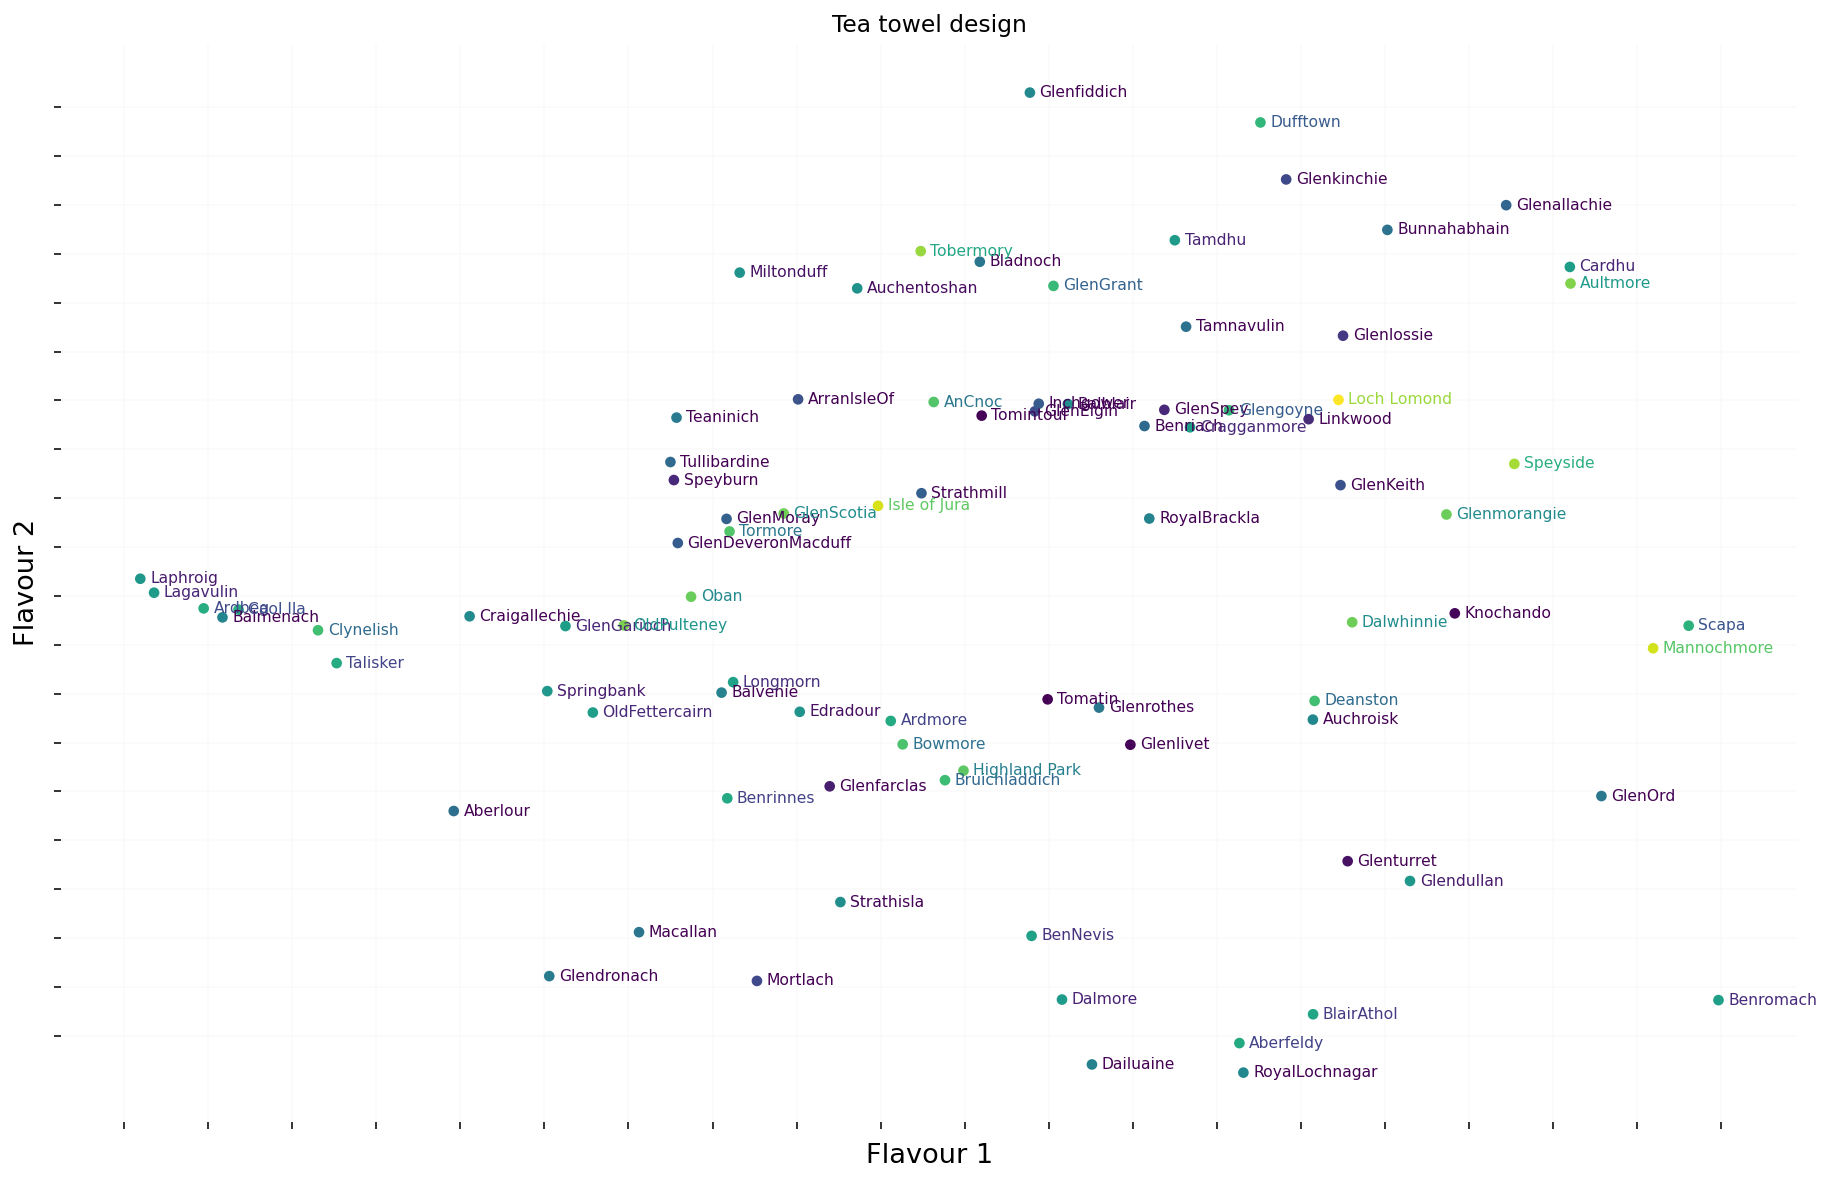

In [81]:
## Show the whisky distilleries laid out
## on the two first principal components,
## colouring the points according to the level of smokiness
## (just to see that similar whiskies are indeed clustered together)
def PCA_plot(projected, names, x="PC1", y="PC2"): 
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(1, 1, 1)
    # ax.set_frame_on(False)
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(y, fontsize=14)
    ax.set_title(
        "Principal component analysis of whisky distillery flavour profiles", fontsize=16
    )
    ax.scatter(
        projected[:, 0],
        projected[:, 1],    
        c=projected[:, 2],    
        s=20,    
        cmap="viridis",
    )
    # ax.scatter(whisky_projected_2d[:,0], whisky_projected_2d[:,1], c=whisky[:,columns['nutty']], s=40)
    texts = []
    for i, name in enumerate(names):
        
        # use annotate instead of text
        ax.annotate(
            name,
            (projected[i, 0], projected[i, 1]),
            xytext=(5, 0),
            textcoords="offset points",     
            fontsize=8,
            va="center",  
            color=plt.cm.viridis(projected[i, 2]),     
        )
    ax.set_xticks(np.linspace(0,3,20))
    ax.set_yticks(np.linspace(-1,1,20))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, alpha=0.05)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax

ax = PCA_plot(whisky_projected_3d, whisky_names, x="Flavour 1", y="Flavour 2")
ax.set_title("Tea towel design")

In [82]:
## Tests
with tick.marks(4):
    assert check_hash(whisky_projected_3d, ((86, 3),17439.036699149292  ))

# E: Mapping flavours to locations

**Note: this part is more challenging and is worth relatively fewer marks; there is also less guidance. Use the original `whisky_vecs` data, not the similarity embedding from Part D.**

There's an ambitious plan to decarbonise Scotland's economy by converting oil rigs to distilleries. To do this, distillers need to know what flavour profiles the rigs should produce -- since they're at sea, they've not got a local tradition, but the distillers are keen that there is some continuity of flavour between the rigs and the mainland distilleries. We need a way of translating between the flavour space and the geographic space.

<img src="imgs/whisky_rigs.png" width="50%"> 

*[The future of Scottish industry?]*

---

## Task E.1 Utility functions

We'll need some simple utilities:

* Write a function `normalise(X)` that normalises a dataset by subtracting the mean and dividing by the column std. devs, returning `mean, std, X_normalised`. 
* Write a function `unnormalise(X_n, mean, std)` that exactly reverses this process, returning the original `X`.
* Write a function `crosscov(X, Y)` that computes the cross-covariance between two datasets, returning the (cross-)covariance matrix. This is just $$C_{XY} = \frac{1}{N}X_\mu^TY_\mu,$$ where $N$ is the number of datapoints and $X_\mu$ means $X - \text{mean}(X)$. Note: **don't try and use np.cov() here**
* Write a function `inv_sqrt(X)` that computes the matrix inverse square root ($X^{-1/2}$) of a (square, symmetric) matrix. 




In [83]:
# YOUR CODE HERE
def normalise(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_n = (X - mean) / std
    return mean, std, X_n

def unnormalise(mean, std, X_n):
    X_origin = X_n * std + mean
    return X_origin

def crosscov(X, Y):
    N = X.shape[0]
    X_mean = np.mean(X, axis=0)
    Y_mean = np.mean(Y, axis=0)
    Cxy = (1 / N) * np.dot((X - X_mean).T, (Y - Y_mean))
    return Cxy

def inv_sqrt(X):
    eigenvals, eigenvecs = np.linalg.eigh(X)
    inv_sqrt_eigenvals = 1 / np.sqrt(eigenvals)
    inv_sqrt_X = np.dot(eigenvecs, np.dot(np.diag(inv_sqrt_eigenvals), eigenvecs.T))
    return inv_sqrt_X

In [84]:
## Tests
with tick.marks(2):
    rng = np.random.RandomState(2026)
    x = rng.normal(0, 4, (100, 3)) * 3 + np.array([1,2,3])
    mu, std, xn = normalise(x)
    assert np.mean(xn) < 1e-10
    assert np.std(xn) - 1 < 1e-10

In [85]:
## Tests
with tick.marks(2):
    assert np.allclose(unnormalise(mu, std, xn), x)

In [86]:
## Tests
with tick.marks(2):
    rng = np.random.RandomState(2021)
    x = rng.normal(0, 1, (200, 3))        
    assert np.allclose(np.cov(x, rowvar=False), crosscov(x, x), atol=4e-2)
    y = rng.normal(0, 1, (200, 6)) * 5 + np.array([1,2,3,4,5,6])       
    assert np.allclose(np.cov(y, rowvar=False), crosscov(y, y), atol=2e-1)
    assert crosscov(x,y).shape == (3,6)
    assert crosscov(y,x).shape == (6,3)
    

In [87]:
## Tests
with tick.marks(2):
    rng = np.random.default_rng(1336)
    k = rng.normal(1, 1, (90,8))
    t = np.cov(k, rowvar=False)            
    assert np.allclose(inv_sqrt(t) @ t @ inv_sqrt(t), np.eye(t.shape[0]))


## Task E.2 Aligning

Now, we will *align* the flavour space with the geographic space. We will do this by implementing the following equations using the functions you just implemented:
* Normalise $X$ and $Y$.
* Compute $$U, S, V^T = \text{svd}(C_{XX}^{-1/2}C_{XY}C_{YY}^{-1/2}),$$ where $C_{XX}$ the covariance of $X,X$, $C_{YY}$ is the covariance of $Y,Y$, and $C_{XY}$ is the cross-covariance of $X$ and $Y$. 
* Compute $$K = U_kV_k^T,$$ where $U_k$ is the first $k$ columns of $U$ and $V_k^T$ is the first $k$ rows of $V^T$.
* Now, we can project to the new space by computing $$Y_{pred} = XK$$
* Unnormalise the resulting $Y_{pred}$ to get the final result.

Write a function to apply this operation, and apply it to the flavour and locations data to get *predicted* locations in the original OS grid coordinates from the original flavour vectors. Store the result in `whisky_projected`.  

In [88]:
# YOUR CODE HERE
def align_flavour_geographic(X, Y, k):
    mean_X, std_X, X_normalized = normalise(X)
    mean_Y, std_Y, Y_normalized = normalise(Y)
    
    C_xx = crosscov(X_normalized, X_normalized)
    C_yy = crosscov(Y_normalized, Y_normalized)
    C_xy = crosscov(X_normalized, Y_normalized)
    
    U, S, VT = np.linalg.svd(inv_sqrt(C_xx) @ C_xy @ inv_sqrt(C_yy))
    
    U_k = U[:, :k]
    VT_k = VT[:k, :]
    K = U_k @ VT_k
    
    Y_pred = X_normalized @ K
    Y_final = unnormalise(mean_Y, std_Y, Y_pred)
    
    return Y_final

k=2
whisky_projected = align_flavour_geographic(whisky_vecs, whisky_locations, k)


In [89]:
## Tests
with tick.marks(4):
    assert check_hash(whisky_projected, ((86, 2), 8102298804.329534  ))

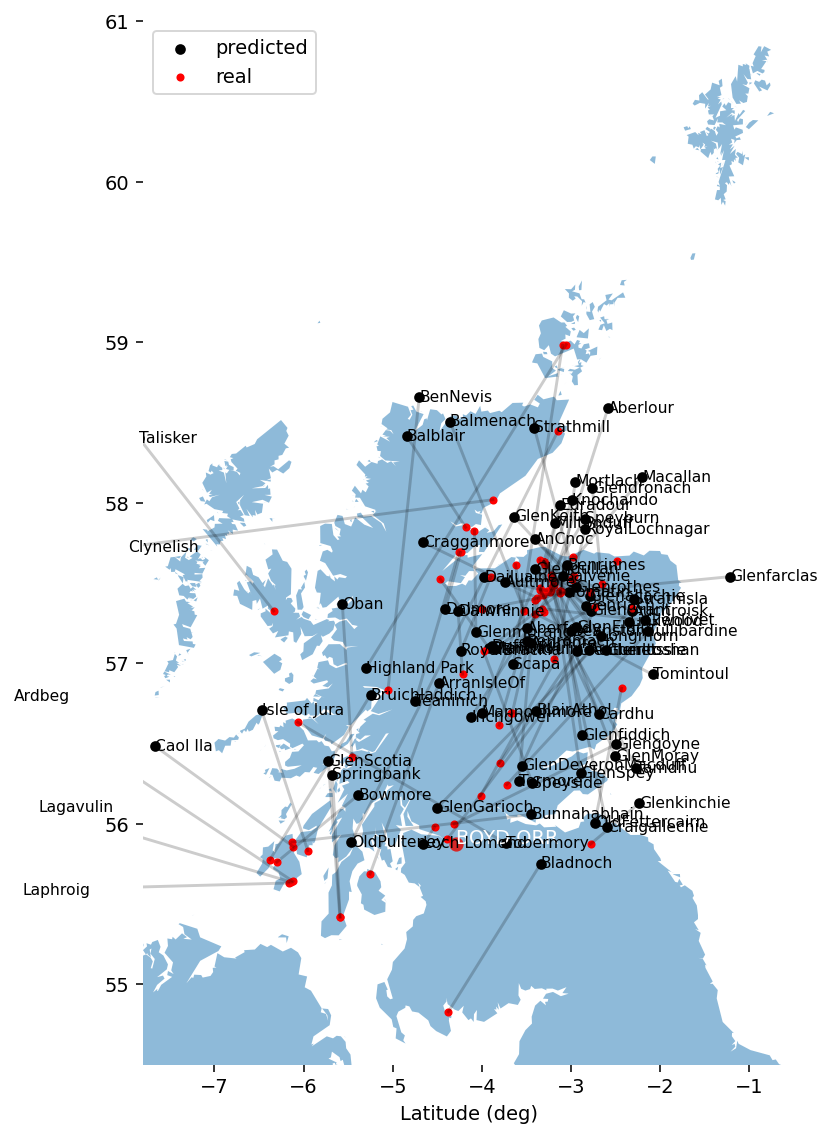

In [90]:
# draw each distillery label at the locations given.
# note that the predictions of location are quite variable; the flavour isn't a perfect indicator of geography
# though it is closely related
from whisky_map import map_coords
ax = draw_map(None, None)
proj_pred = map_coords(whisky_projected)
proj_real = map_coords(whisky_locations)
ax.scatter(proj_pred[:,0], proj_pred[:,1], s=20, c="k", label="predicted")
ax.scatter(proj_real[:,0], proj_real[:,1], s=10, c="r", label="real")
ax.legend()
for i in range(len(whisky_names)):
    ax.plot([proj_pred[i,0], proj_real[i,0]], [proj_pred[i,1], proj_real[i,1]], c="k", alpha=0.2)
    ax.text(proj_pred[i,0], proj_pred[i,1], whisky_names[i], fontdict={"fontsize":8}, va="center")

### Task E.3 Finding a good rig
You've computed the best *linear* map between flavour profiles and geographical locations (it is the $K$ you computed above). Now you can use it to predict the location of a new whisky from its flavour profile.

A distiller has produced a spirit with the flavour profile `rig_flavour` below (in the original, unnormalised flavour space). Where in the sea should they locate the distillery rig to be closest to where customers would expect to find it?

There are forty decomissioned rigs that could be used for distilling stored in the file `data/decomissioned_rigs.txt` (in the same OS coordinates as in the whisky dataset).  

To help the distiller prioritise where to produce their whisky, create an ordered sequence of oil rigs in `rig_choices`, where the first value is the index of the rig closest to the ideal geographical location, the second value is the second closest, etc.


In [91]:
# the new spirit's flavour
rig_flavour = [2.7, 3.9, 1.3, 0.7,1.2, 2.9, 3.2,  3.2, 2.5, 3.0, 2.8, 1.7]

# load the rig positions a
all_rigs = np.loadtxt("data/decomissioned_rigs.txt")
print(all_rigs.shape)

(40, 2)


NameError: name 'rig_choices' is not defined

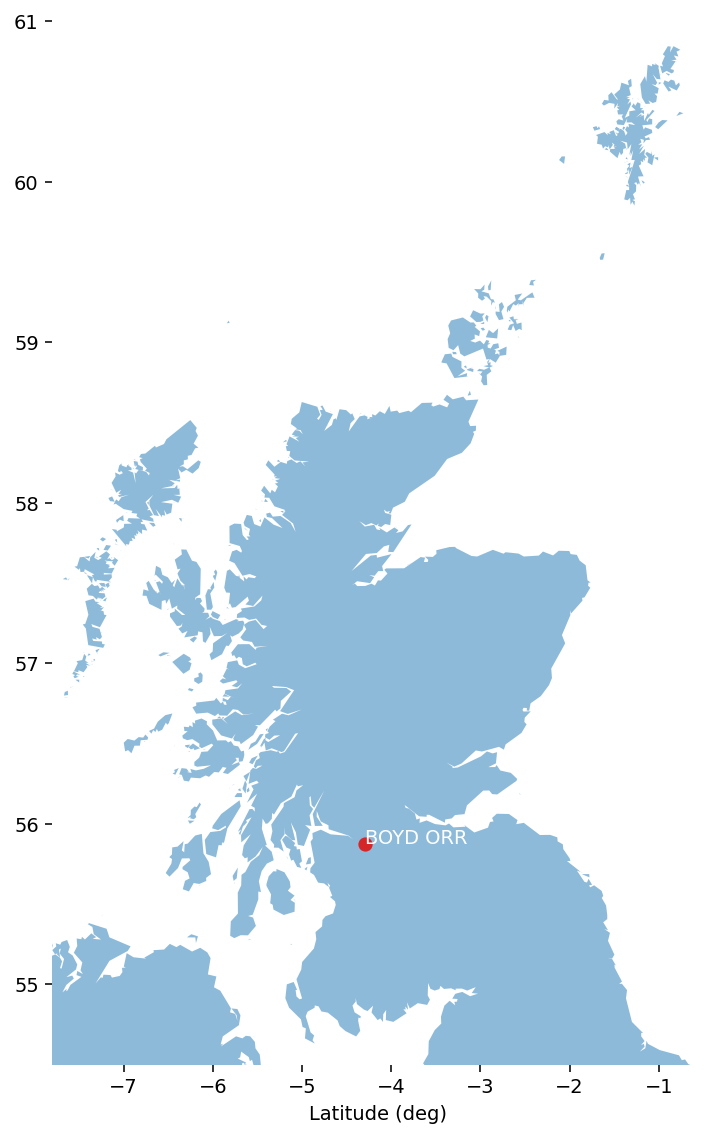

In [92]:
## Tests
ax = draw_map(None, None)
plot_rigs = map_coords(all_rigs)
c = ax.scatter(plot_rigs[:,0], plot_rigs[:,1], marker='+', c=np.argsort(rig_choices)/40.0, cmap="viridis")
plt.colorbar(c, shrink=0.7)
with tick.marks(3):
    assert case_crc("\n".join([f"{ix:.0f}" for ix in rig_choices.ravel()])) == 954617488

### Task E.4 Stocking the bar
The rig managers want to test out tours on the rigs before the spirit has been produced. They're going to stock each of the forty rigs with supplies of the whisky that best matches the flavour expected at that location.

Compute a list `rig_bottles` that has the names of the best distilleries to stock each rig with. Note: you'll need to think about how to *reverse* the mapping that $K$ performs.


In [ ]:
# YOUR CODE HERE

In [ ]:
## Tests
from collections import defaultdict
ax = draw_map(None, None)
plot_rigs = map_coords(all_rigs)

# group the distillery names
groups = defaultdict(list)
for b, xy in zip(rig_bottles, plot_rigs):
    groups[b].append(xy)

# plot each group of names in its own layer
cs = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
for c, (name, xys) in zip(cs, groups.items()):
    xys = np.array(xys)
    ax.scatter(xys[:,0], xys[:,1], marker='+', label=name, c=c)
    ctr = np.mean(xys, axis=0)
    ax.text(ctr[0], ctr[1], name, c=c)
    
with tick.marks(3):
    assert case_crc(" ".join(rig_bottles)) == 3388300128

## END OF LAB

-----

# Submission instructions

## Before submission

* Make sure you fill in any place that says `YOUR CODE HERE` or `"YOUR ANSWER HERE"`.
* SAVE THE NOTEBOOK
* DO NOT RENAME THE NOTEBOOK OR IT WILL NOT BE MARKED.

<div class="alert alert-block alert-danger">
    
### Formatting the submission
* **WARNING**: If you do not submit the correct file, you will not get any marks.
* Submit this file **only** on Moodle. It will be named `<xxx>.ipynb`.

</div>


## Penalties (only for assessed labs)
<font color="red">
    
**Malformatted submissions**
</font>
These assignments are processed with an automatic tool; failure to follow instructions *precisely* will lead to you automatically losing two bands in grade regardless of whether the work is correct (not to mention a long delay in getting your work back). **If you submit a file without your work in it, it will be marked and you will get 0 marks.**

<font color="red">**Late submission**</font>
Be aware that there is a two band penalty for every *day* of late submission, starting the moment of the deadline.

<font color="red">
    
**Plagiarism**
</font> Plagiarism will be subject to the Plagiarism Policy. The penalties are severe.